# Portfolio Optimization


In this chapter, we will show how to solve a portfolio optimization problem. The notebook code snippets we will execute are based on an existing repository, you can find this repository and more information via https://github.com/Qiskit/qiskit-finance/blob/stable/0.3/docs/tutorials/01_portfolio_optimization.ipynb. 

We will solve the following problem:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

First, like always, we need to import the necessary packages and frameworks.

In [1]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

After we’ve imported all the packages, we will define the problem and write it out in code. We will be using a random portfolio problem in the example shown below.

In [2]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

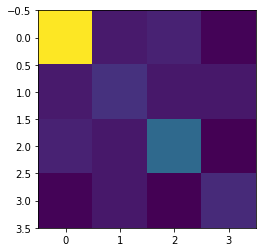

In [3]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

We set the risk factor to 0.5, the budget at 2, and we set the parameter to scale the budget penalty term.

In [4]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.015284386652 x_0 + 0.000780952145 x_1 - 0.000517920547 x_2
      - 0.000870005837 x_3 + [ 0.002541388592 x_0^2 + 0.000146804433 x_0*x_1
      + 0.000257201062 x_0*x_2 - 0.000199722426 x_0*x_3 + 0.000258486713 x_1^2
      + 0.000106085519 x_1*x_2 + 0.000088963242 x_1*x_3 + 0.000791504681 x_2^2
      - 0.000247774763 x_2*x_3 + 0.000197892585 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

We will then define some utility methods to lay out the results afterwards.

In [5]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

Now we can start to try to solve the optimization problem. We will show you three ways: via the classical way, using VQE and lastly, using QAOA.

Let’s start with the classical way. We will use the NumPyMinimumEigensolver. Bear in mind that this is not using quantum computing. 

In [6]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		1.0000
 [1 1 1 1]	4.0656		0.0000
 [0 1 1 1]	1.0199		0.0000
 [1 0 1 1]	1.0049		0.0000
 [0 0 1 1]	-0.0010		0.0000
 [1 1 0 1]	1.0060		0.0000
 [0 1 0 1]	0.0002		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 1 1 0]	1.0069		0.0000
 [0 1 1 0]	0.0008		0.0000
 [1 0 1 0]	-0.0140		0.0000
 [0 0 1 0]	1.0197		0.0000
 [1 1 0 0]	-0.0130		0.0000
 [0 1 0 0]	1.0208		0.0000
 [1 0 0 0]	1.0059		0.0000
 [0 0 0 0]	4.0795		0.0000


## Solution using VQE

Secondly, we can use VQE (or Variational Quantum Eigensolver). We must specify the optimizer and variational form that needs to be used

In [7]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.8483
 [0 0 1 1]	-0.0010		0.1039
 [1 1 0 0]	-0.0130		0.0438
 [0 1 1 0]	0.0008		0.0020
 [1 0 1 0]	-0.0140		0.0016
 [0 1 0 1]	0.0002		0.0003
 [0 1 1 1]	1.0199		0.0000
 [0 0 1 0]	1.0197		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 0 0 0]	1.0059		0.0000
 [1 0 1 1]	1.0049		0.0000
 [0 1 0 0]	1.0208		0.0000
 [1 1 1 0]	1.0069		0.0000
 [1 1 0 1]	1.0060		0.0000
 [1 1 1 1]	4.0656		0.0000
 [0 0 0 0]	4.0795		0.0000


### Solution using QAOA

Lastly, we will use the Quantum Approximate Optimization Algorithm (or QAOA).

In [8]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.1684
 [1 0 1 0]	-0.0140		0.1683
 [1 1 0 0]	-0.0130		0.1680
 [0 0 1 1]	-0.0010		0.1653
 [0 1 0 1]	0.0002		0.1651
 [0 1 1 0]	0.0008		0.1649
 [0 0 0 0]	4.0795		0.0000
 [1 1 1 1]	4.0656		0.0000
 [1 0 1 1]	1.0049		0.0000
 [1 1 0 1]	1.0060		0.0000
 [1 1 1 0]	1.0069		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 1 0]	1.0197		0.0000
 [0 0 0 1]	1.0191		0.0000
 [0 1 1 1]	1.0199		0.0000
 [1 0 0 0]	1.0059		0.0000
